In [41]:
%load_ext autoreload 

from tqdm import tqdm
import matplotlib.pyplot as plt
import plotly.express as px
import numpy as np
from easydict import EasyDict as edict
import pandas as pd
import os
from collections import defaultdict
from joblib import Parallel, delayed
import multiprocessing as mp
from IPython.core.debugger import set_trace
from IPython.display import clear_output
import copy

from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.datasets import make_swiss_roll,\
                             make_s_curve,\
                             make_moons

from umap import UMAP

import torch
from torch import nn
from torch import optim
from torch import autograd

from torch.utils.data import DataLoader

from train_utils import get_capacity, plot_weights_hist, train, get_grad_params, criterion_rule
from metric_utils import calculate_Q_metrics, \
                         strain, \
                         l2_loss, \
                         to_numpy, \
                         numpy_metric, \
                         cosine_sim

from input_utils import DataGenerator, make_random_affine
from mlp_model import MLP_NonlinearEncoder
from models_utils import init_weights, \
                         universal_approximator, \
                         sigmoid, \
                         initialize_nonlinearities

from embedding_utils import ConstructUMAPGraph, UMAPLoss, UMAPDataset, umap_criterion_compatibility

from pynndescent import NNDescent
from umap.umap_ import fuzzy_simplicial_set, make_epochs_per_sample
from sklearn.utils import check_random_state

import pygad
from torchga import TorchGA, model2vector, vector2model

import warnings
warnings.filterwarnings("ignore")

plt.rcParams['font.size'] = 20
device = torch.device('cuda:0')
N_CPU = mp.cpu_count()
SEED = 42
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load data 

In [42]:
SCALER = StandardScaler()

input_parameters = {'generator': make_swiss_roll, #make_s_curve, 
                    'generator_kwargs': {'n_samples':10000, 'noise':1e-2}, # 1e-1
                    'unsupervised':True,
                    'whiten':True,
                    'scaler':SCALER,
                    'use_outpt_color':True} 

create_data = DataGenerator(**input_parameters)

inpt, _, color = create_data()

N_TEST = 1000

In [43]:
inpt.mean(1), inpt.std(1)

(array([-6.92779167e-18,  1.52766688e-16,  3.41060513e-17]),
 array([1., 1., 1.]))

In [44]:
inpt.max(1), inpt.min(1), (inpt@inpt.T / inpt.shape[1]).round()

(array([1.6014587 , 1.76912241, 2.01589531]),
 array([-1.73284977, -1.71244097, -1.61998356]),
 array([[ 1.,  0.,  0.],
        [ 0.,  1., -0.],
        [ 0., -0.,  1.]]))

In [45]:
inpt_train, inpt_test, color_train, color_test = train_test_split(inpt.T, 
                                                                  color, 
                                                                  random_state=42,
                                                                  test_size=N_TEST)

In [46]:
inpt_train_torch = torch.tensor(inpt_train, dtype=torch.float32).to(device)
inpt_test_torch = torch.tensor(inpt_test, dtype=torch.float32).to(device)

In [47]:
inpt_train_torch.shape, inpt_test_torch.shape

(torch.Size([9000, 3]), torch.Size([1000, 3]))

# Setup dataloders

In [48]:
graph_constructor = ConstructUMAPGraph(metric='euclidean', 
                                        n_neighbors=15, 
                                        random_state=SEED)

# (epochs_per_sample, head, tail, weight) 
train_graph_data = graph_constructor(inpt_train)
test_graph_data = graph_constructor(inpt_test)

BATCH_SIZE_BP = 2

dataset_train = UMAPDataset(inpt_train, 
                            *train_graph_data, 
                            device=device, 
                            batch_size=BATCH_SIZE_BP)

# dataset_test = UMAPDataset(inpt_test, 
#                            *test_graph_data, 
#                            device=device,
#                            batch_size=BATCH_SIZE_BP)

Mon Jul 11 17:13:49 2022 Building RP forest with 10 trees
Mon Jul 11 17:13:49 2022 NN descent for 13 iterations
	 1  /  13
	 2  /  13
	Stopping threshold met -- exiting after 2 iterations
Mon Jul 11 17:13:49 2022 Building RP forest with 7 trees
Mon Jul 11 17:13:49 2022 NN descent for 10 iterations
	 1  /  10
	 2  /  10
	Stopping threshold met -- exiting after 2 iterations


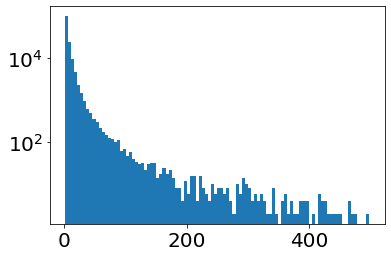

In [74]:
plt.hist(train_graph_data[0], bins=100)
plt.yscale('log')
plt.show()

In [77]:
criterion_umap = UMAPLoss(device=device, 
                         min_dist=0.1,
                         negative_sample_rate=0,
                         edge_weight=None,
                         repulsion_strength=1.0)

# Adjacent grad

In [78]:
LEARNING_TYPE = 'Criterion' 

encoder_parameters = {
                    'input_dim':inpt.shape[0],
                    'hidden_dim':50,
                    'embedding_dim':2,
                    'add_readout':False,
                    'hebbian_update':criterion_rule,
                    'inplace_update':True,
                    'normalize_hebbian_update':True,
                    'lr_hebb':1e-4,
                    'parametrized_f':True,
                    'W_requires_grad':False,
                    'f_requires_grad':True,
                    'final_nonlinearity':False,
                    'nonlinearity': universal_approximator,
                    'f_kwargs':{'hidden_dim':10, 'requires_grad':True},
                    'layers_number':3,
                    'add_bn':False,
                    'seed':None,
                    'set_seed':False,
                     }


training_parameters = edict({'epochs':10,
                           'enable_grad_train':False,
                           'enable_grad_val':False,
                           'maxiter':1000, # maxiter
                           'shuffle':True, # shuffle data
                           'progress_bar':True,
                           'weight_saver':None,
                           'calculate_grad':False,
                           'clip_grad_value': None,
                           'val_metrics':None,
                           'device':device
                          })

criterion_kwargs = defaultdict(dict)
criterion_kwargs['skip_train'] = True
criterion_kwargs['skip_val'] = True

network = MLP_NonlinearEncoder(**encoder_parameters).to(training_parameters['device'])
opt = optim.Adam(get_grad_params(network.parameters()), lr=1e-4)
baseline_state = network.state_dict()

Net capacity: 4770
Parameters:
W_s.0 torch.Size([50, 3]) requires_grad: False Device: cuda:0
W_s.1 torch.Size([50, 50]) requires_grad: False Device: cuda:0
W_s.2 torch.Size([2, 50]) requires_grad: False Device: cuda:0
f_s.0.theta1 torch.Size([10, 50]) requires_grad: True Device: cuda:0
f_s.0.bias1 torch.Size([10, 50]) requires_grad: True Device: cuda:0
f_s.0.theta2 torch.Size([1, 10]) requires_grad: True Device: cuda:0
f_s.1.theta1 torch.Size([10, 50]) requires_grad: True Device: cuda:0
f_s.1.bias1 torch.Size([10, 50]) requires_grad: True Device: cuda:0
f_s.1.theta2 torch.Size([1, 10]) requires_grad: True Device: cuda:0


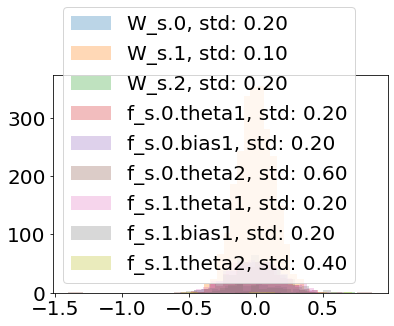

In [79]:
print('Net capacity:', get_capacity(network))
print('Parameters:')

for name, param in network.named_parameters():
    print(name, param.shape, 'requires_grad:', param.requires_grad, 'Device:', param.device)
    W = to_numpy(param.data)
    std = W.std().round(1)
    plt.hist(W.flatten(),bins=20, alpha=0.3, label='{}, std: {:.2f}'.format(name, std))
plt.legend()
plt.show()

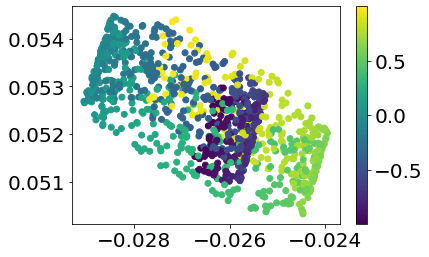

In [80]:
X_s = network.forward(inpt_test_torch.to(training_parameters['device']))
outpt_val_pred = to_numpy(X_s[-1])

plt.figure()
plt.scatter(outpt_val_pred[0],
            outpt_val_pred[1], 
            c=color_test
           )
plt.colorbar()
plt.show()

In [ ]:
iterator = iter(dataset_train)

losses_per_trial = []

for t in tqdm(range(100)):

    batch = next(iterator)
    network = MLP_NonlinearEncoder(**encoder_parameters).to(training_parameters['device'])
    opt = optim.Adam(get_grad_params(network.parameters()), lr=1e-4)    

    X_to, X_from = batch
    X_to, X_from = X_to.unsqueeze(0), X_from.unsqueeze(0)

    with torch.no_grad():
        network.inplace_update = False
        # obtain one embedding point
        X_s_to = network(X_to)

    losses_ = []
    for i in range(500):

        # calculate differentiable embedding for another one,
        # given we made a hebbian update on `X_from`
        network.inplace_update = True
        X_s_from = network(X_from)

        # calculate loss for `f_s`, given update on `X_from` is done
        Y = torch.cat([X_s_to[-1].T, X_s_from[-1].T], dim=0)
        loss_umap = criterion_umap(Y)

        # gradient update for `f_s`
        opt.zero_grad()
        loss_umap.backward(retain_graph=True)
        opt.step()

        losses_.append(loss_umap.item())

    losses_per_trial.append(losses_)

 50%|███████████████████████████████████████████████████████████████▌                                                               | 50/100 [01:27<01:28,  1.77s/it]

In [ ]:
for l in losses_per_trial:
    plt.plot(l)

In [24]:
# for itr,batch in enumerate(dataset_train):
#     break

# losses_per_trial = {}
# for num_df_before_dW in range(1,20,2):

#     network.load_state_dict(baseline_state)

#     losses_ = []

#     X_to, X_from = batch
#     X_to, X_from = X_to.unsqueeze(0), X_from.unsqueeze(0)

#     for i in tqdm(range(1000)):

#         with torch.no_grad():
#                 network.inplace_update = False
#                 # obtain one embedding point
#                 X_s_to = network(X_to)
        
#         # `f` updates
#         for _ in range(num_df_before_dW):
            
#             # calculate differentiable embedding for another one,
#             # given we made a hebbian update on `X_from`
#             network.inplace_update = True
#             X_s_from = network(X_from)

#             # calculate loss for `f_s`, given update on `X_from` is done
#             Y = torch.cat([X_s_to[-1].T, X_s_from[-1].T], dim=0)
#             loss_umap = criterion_umap(Y)

#             # gradient update for `f_s`
#             opt.zero_grad()
#             loss_umap.backward(retain_graph=True, create_graph=True)
#             opt.step()

#             losses_.append(loss_umap.item())

#     #     # hebbian update of `X_to`
#     #     network.inplace_update = False
#     #     X_s = network(X_to)
#     #     network.hebbian_learning_step(X_s)

#         # hebbian update of `X_from`
#         network.inplace_update = False
#         X_s = network(X_from)
#         network.hebbian_learning_step(X_s)

#     losses_per_trial[num_df_before_dW] = losses_

In [25]:
# for k,v in losses_per_trial.items():
#     plt.figure()
#     plt.plot(v, label=k)
#     plt.show()

In [15]:
# forward pass
maxiter = 100 #np.inf
metric_iter_freq = 1000

losses_train = []
losses_val = []

epochs = 1
num_df_before_dW = 10

for ep in range(epochs):
    for itr, batch in tqdm(enumerate(dataset_train)):

        if itr >= maxiter:
            break

        assert batch.shape[0] == 2
        X_to, X_from = batch
        X_to, X_from = X_to.unsqueeze(0), X_from.unsqueeze(0)
        
        # fix `X_to`
        with torch.no_grad():
            network.inplace_update = False
            # obtain one embedding point
            X_s_to = network(X_to)
        
        # update for `X_from`
        for _ in range(num_df_before_dW):
            # calculate differentiable embedding for another one,
            # given hebbian update on `X_from`
            network.inplace_update = True
            X_s_from = network(X_from)

            # calculate loss for `f_s`, given update on `X_from` is done
            Y = torch.cat([X_s_to[-1].T, X_s_from[-1].T], dim=0)
            loss_umap = criterion_umap(Y)

            # gradient update for `f_s`
            opt.zero_grad()
            loss_umap.backward(retain_graph=True)
            opt.step()
            
            losses_train.append(loss_umap.item())

        # hebbian update of `X_from`
        network.inplace_update = False
        X_s = network(X_from)
        network.hebbian_learning_step(X_s)
        
        X_s = network.forward(inpt_test_torch.to(training_parameters['device']))
        
        if itr%metric_iter_freq == 0:
            X_s = network.forward(inpt_test_torch.to(training_parameters['device']))
            losses_val.append(criterion_umap(X_s[-1].T).item())

#     state_dicts.append(network.state_dict())

100it [00:03, 27.60it/s]


In [16]:
criterion_umap(Y)

tensor(9.5367e-07, device='cuda:0', grad_fn=<MeanBackward0>)

In [17]:
Y

tensor([[1.0156, 0.6482],
        [1.0153, 0.6481]], device='cuda:0', grad_fn=<CatBackward>)

In [18]:
X_s_from[-1], X_s_to[-1], 

(tensor([[1.0153],
         [0.6481]], device='cuda:0', grad_fn=<MmBackward>),
 tensor([[1.0156],
         [0.6482]], device='cuda:0'))

In [19]:
len(losses_val), len(losses_train)

(1, 1000)

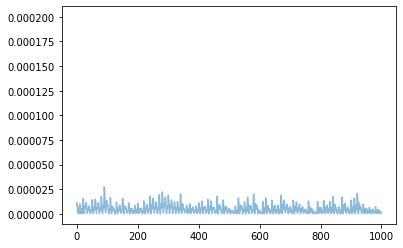

In [20]:
time = np.arange(len(losses_train))
plt.plot(time, losses_train, alpha=0.5)
plt.plot(time[::metric_iter_freq*num_df_before_dW], losses_val, color='red')

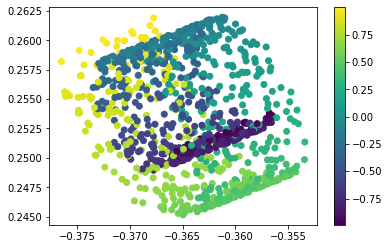

In [29]:
X_s = network.forward(inpt_test_torch.to(training_parameters['device']))
outpt_val_pred = to_numpy(X_s[-1])

plt.figure()
plt.scatter(outpt_val_pred[0],
            outpt_val_pred[1], 
            c=color_test
           )
plt.colorbar()
plt.show()